# TabNet example classification for Adult Census Income dataset

This notebook shows 
  - a simple workflow using TabNet for classification of the [Adult Census Income](https://archive.ics.uci.edu/ml/datasets/adult) dataset
  - how to get global feature importances from the model
  - how to show local feature importances (masks) from the model
  - a comparison to XGBoost and LightGBM


In [1]:
try:
  from pytorch_tabnet.tab_model import TabNetClassifier
except:
  !pip install pytorch-tabnet
  from pytorch_tabnet.tab_model import TabNetClassifier

In [2]:
try:
  import wget
except:
  !pip install wget
  import wget

In [3]:
import torch; print('torch: ', torch.__version__)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd; print('pandas:', pd.__version__)
import numpy as np

import os
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

import psutil
print('CPU count:', psutil.cpu_count())

torch:  1.5.1+cu101
pandas: 1.0.5
CPU count: 2


# Download census-income dataset


Adult census-income dataset, extract from the 1994 US census database.

Hosted on: https://archive.ics.uci.edu/ml/datasets/adult


In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
path_out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [5]:
path_out.parent.mkdir(parents=True, exist_ok=True)
if path_out.exists():
    print("File already exists.")
else:
    print(f"Downloading file to {path_out}...", end='')
    wget.download(url, path_out.as_posix())
    print('done')

File already exists.


# Load data and split

In [6]:
# csv file comes without column names
column_names = [
  'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'maritial-status',
  'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
  'hours-per-week', 'native-country', 'target'
]

train = pd.read_csv(path_out, header=None, names=column_names)
print(f'loaded data with shape: {train.shape}\n')
print('dtypes:')
print(str(train.dtypes.value_counts()).split("\ndtype")[0])

loaded data with shape: (32561, 15)

dtypes:
object    9
int64     6


In [7]:
train.head()

,age,workclass,fnlwgt,education,education-num,maritial-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
columns = pd.DataFrame({'column':train.columns})
columns['dtype'] = train.dtypes.values
columns['nunique'] = train.nunique().values
columns['missing'] = train.isnull().sum().values
columns

,column,dtype,nunique,missing
0,age,int64,73,0
1,workclass,object,9,0
2,fnlwgt,int64,21648,0
3,education,object,16,0
4,education-num,int64,16,0
5,maritial-status,object,7,0
6,occupation,object,15,0
7,relationship,object,6,0
8,race,object,5,0
9,sex,object,2,0


In [9]:
target = 'target'
print(train['target'].value_counts())

 <=50K    24720
 >50K      7841
Name: target, dtype: int64


In [10]:
np.random.seed(42)

if "set" not in train.columns:
    train["set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train["set"]=="train"].index
valid_indices = train[train["set"]=="valid"].index
test_indices  = train[train["set"]=="test" ].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [11]:
exclude = ['target', 'set']

In [12]:
def get_categorical_columns(df, exclude:list, max_nunique=200) -> list:
  "get a list of categorical columns, either type object or fewer than max_nunique values"
  
  columns_catg = [c for c in df.drop(exclude, axis=1).columns 
                  if (df[c].nunique()<max_nunique 
                      or df[c].dtype=='object') 
                  and c.endswith('__label')==False
                  ]
  return columns_catg


def get_categorical_features(df) -> list:
  "get list of numerical categorical features"
  feats_catg = [c for c in df.columns if c.endswith('__label')]
  return feats_catg

In [13]:
columns_catg = get_categorical_columns(train, exclude, max_nunique=200)
columns_catg

['age',
 'workclass',
 'education',
 'education-num',
 'maritial-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

In [14]:
  # create new label encoded categorical columns
  for col in columns_catg:
    train[col] = train[col].fillna("00_MISSING")
    train[col+'__label'] = LabelEncoder().fit_transform(train[col].values)

  features_catg = get_categorical_features(train)
  features_catg

['age__label',
 'workclass__label',
 'education__label',
 'education-num__label',
 'maritial-status__label',
 'occupation__label',
 'relationship__label',
 'race__label',
 'sex__label',
 'capital-gain__label',
 'capital-loss__label',
 'hours-per-week__label',
 'native-country__label']

# Define categorical features for categorical embeddings

In [15]:
features_all = [col for col in train.select_dtypes('number').columns
                if col not in exclude]

features_catg_idxs = [i for i, f in enumerate(features_all) if f in features_catg]
print('features: ', features_all)
print('catg idxs:', features_catg_idxs)

features:  ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'age__label', 'workclass__label', 'education__label', 'education-num__label', 'maritial-status__label', 'occupation__label', 'relationship__label', 'race__label', 'sex__label', 'capital-gain__label', 'capital-loss__label', 'hours-per-week__label', 'native-country__label']
catg idxs: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


# Splits

In [16]:
X_train = train[features_all].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features_all].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features_all].values[test_indices]
y_test = train[target].values[test_indices]

print('train:', X_train.shape, '| valid:', X_valid.shape, '| test:', X_test.shape)

train: (26070, 19) | valid: (3249, 19) | test: (3242, 19)


# TabNet

In [17]:
def get_categorical_dims(df, features_catg) -> list:
  "get list ov dimensions for each categorical column"
  return list(df[features_catg].nunique().values)


def get_embedding_dims(df, features_catg, method='ln'):
  """
  Calculate dimensions for embeddings per feature. Larger dims can learn more but require longer training.
  Method:
  - int for same size for all features
  - 'sqrt' for square root of category counts
  - 'ln' for logn of category counts
  - 'fastai' for fastai sizes
  """

  emb_dims = []

  for f in features_catg:
    n_unique = df[f].nunique()
    
    if type(method)==int:  emb_dims.append( method )
    elif method=='sqrt':   emb_dims.append( int(np.sqrt(n_unique)) )
    elif method=='ln':     emb_dims.append( max(int(np.log(n_unique)), 1) )
    elif method=='fastai': emb_dims.append( min(600, round(1.6 * n_unique**0.56)) )

  return emb_dims

In [18]:
cat_dims = get_categorical_dims(train, features_catg)
print('cat dims:    ', cat_dims)

cat_emb_dim = get_embedding_dims(train, features_catg, method='ln')
print('cat emb dims:', cat_emb_dim)

cat dims:     [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]
cat emb dims: [4, 2, 2, 2, 1, 2, 1, 1, 1, 4, 4, 4, 3]


In [19]:
# create classifier, default values
clf = TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3,
                       cat_idxs=features_catg_idxs, 
                       cat_dims=cat_dims,
                       cat_emb_dim=cat_emb_dim
                       )

Device used : cpu


## Training

In [20]:
# default values, takes about 300s on a 2 core CPU (Google Colab)
clf.fit(  
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=100 , patience=20, 
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

print('best score:', -clf.best_cost)

Will train until validation stopping metric hasn't improved in 20 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.71387 |  0.68024 |   3.7       
| 2     | 0.83451 |  0.69103 |   7.2       
| 3     | 0.85790 |  0.82775 |   10.7      
| 4     | 0.87081 |  0.82252 |   14.1      
| 5     | 0.87616 |  0.86984 |   17.5      
| 6     | 0.88084 |  0.86898 |   21.1      
| 7     | 0.88493 |  0.88552 |   24.7      
| 8     | 0.88720 |  0.89117 |   28.3      
| 9     | 0.88808 |  0.89817 |   31.8      
| 10    | 0.88970 |  0.90091 |   35.5      
| 11    | 0.89160 |  0.89941 |   39.2      
| 12    | 0.89370 |  0.90262 |   42.7      
| 13    | 0.89462 |  0.90502 |   46.1      
| 14    | 0.89511 |  0.90566 |   49.4      
| 15    | 0.89661 |  0.90235 |   52.8      
| 16    | 0.89665 |  0.90448 |   56.1      
| 17    | 0.89741 |  0.90089 |   59.4      
| 18    | 0.89918 |  0.90743 |   62.6      
| 19    | 0.89898 |  0.90709 |   65.9      
| 20

Different embedding sizes can have an effect on the model quality.

AUC scores per emb_size_method:
```
method   score     time in s
--------|---------|----------
ln         0.93092        305
all 2      0.93013        212
all 1      0.92975        271
sqrt       0.92805        178
fastai     0.92587        296
```
TabNet seems to work just fine with small embedding sizes.

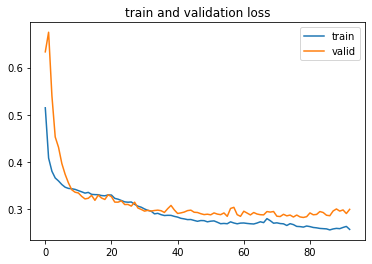

In [21]:
# plot losses
plt.plot(clf.history['train']['loss'], label='train')
plt.plot(clf.history['valid']['loss'], label='valid')
plt.title('train and validation loss');
plt.legend();

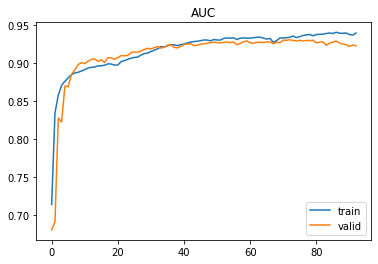

In [22]:
# plot auc
plt.title('AUC')
plt.plot([-x for x in clf.history['train']['metric']], label='train')
plt.plot([-x for x in clf.history['valid']['metric']], label='valid')
plt.legend();

## Predictions

In [23]:
tabnet_preds_test = clf.predict_proba(X_test)
tabnet_test_auc = roc_auc_score(y_score=tabnet_preds_test[:,1], y_true=y_test)

print(f"valid AUC score: {-clf.best_cost}")
print(f"test AUC score : {tabnet_test_auc}")

valid AUC score: 0.9309194548999999
test AUC score : 0.926611365719037


## Global explainability: feat importance summing to 1

In [24]:
feat_imp = (pd.DataFrame({'feature':features_all,
                          'importance':np.round(clf.feature_importances_, 4)})
            .sort_values('importance', ascending=False)
            .reset_index(drop=True)
)
feat_imp.style.bar()

,feature,importance
0,hours-per-week__label,0.167400
1,capital-gain,0.132700
2,age,0.130500
3,education-num,0.080100
4,sex__label,0.075800
5,maritial-status__label,0.070300
6,capital-loss,0.061100
7,relationship__label,0.060600
8,workclass__label,0.053400
9,age__label,0.047200


## Local explainability and masks

In [25]:
explain_matrix, masks = clf.explain(X_test)

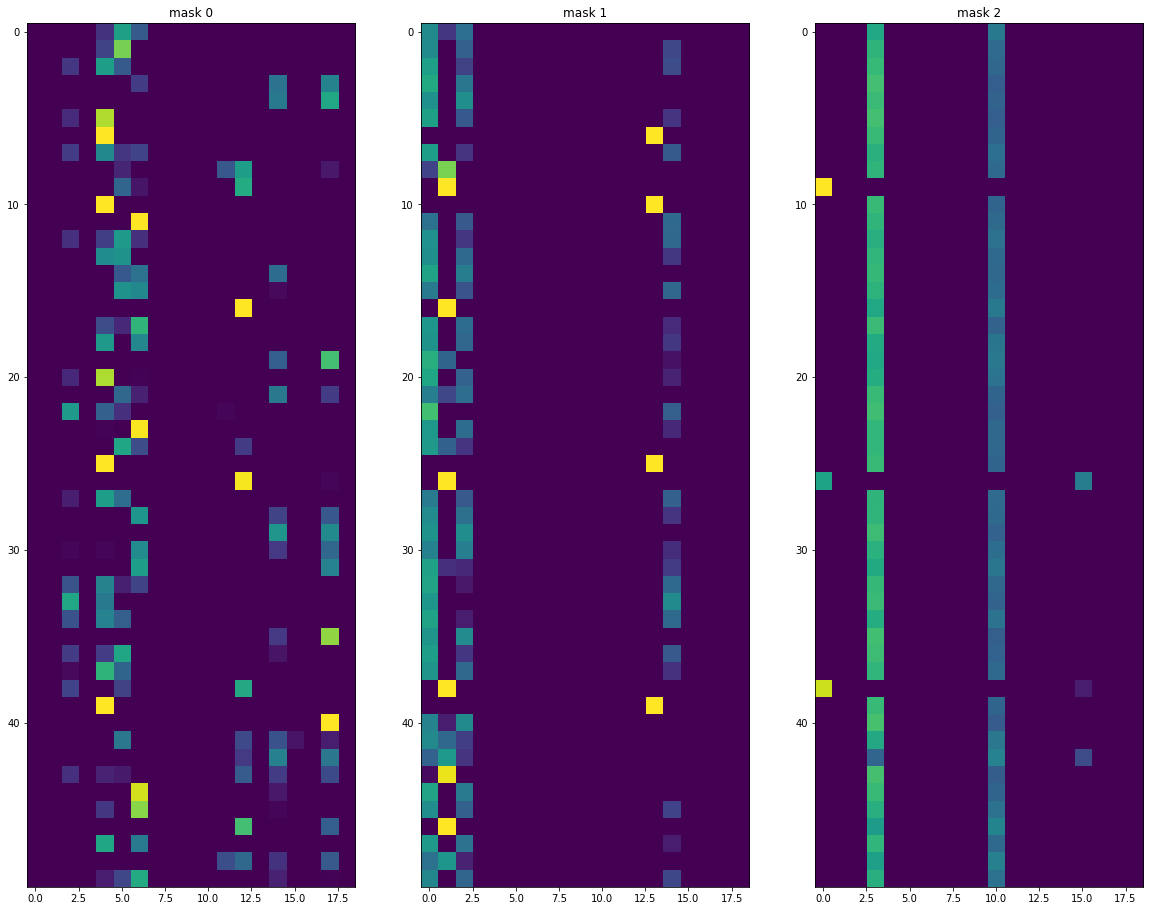

In [26]:
# shows masks per feature for first 50 rows
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# Comparison to XGBoost and LightGBM

## XGBoost

In [27]:
from xgboost import XGBClassifier

In [28]:
%%time
# create XGB Classifier with slightly adjusted values (defaults are underfitting too much)
# takes about 20s
clf_xgb = XGBClassifier( 
    max_depth=7,
    n_estimators=1000,
    n_jobs=-1,
    learning_rate=0.03,
    subsample=0.7,
    # rest are default values, no real fine tuning
    verbosity=0, 
    silent=None, 
    objective='binary:logistic',
    booster='gbtree',
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], eval_metric=['auc'],
            early_stopping_rounds=40,
            verbose=10);

[0]	validation_0-auc:0.898658
Will train until validation_0-auc hasn't improved in 40 rounds.
[10]	validation_0-auc:0.911295
[20]	validation_0-auc:0.91293
[30]	validation_0-auc:0.914427
[40]	validation_0-auc:0.916237
[50]	validation_0-auc:0.917805
[60]	validation_0-auc:0.919076
[70]	validation_0-auc:0.920464
[80]	validation_0-auc:0.921499
[90]	validation_0-auc:0.922259
[100]	validation_0-auc:0.923117
[110]	validation_0-auc:0.923975
[120]	validation_0-auc:0.9246
[130]	validation_0-auc:0.925399
[140]	validation_0-auc:0.926021
[150]	validation_0-auc:0.926525
[160]	validation_0-auc:0.927024
[170]	validation_0-auc:0.927324
[180]	validation_0-auc:0.927655
[190]	validation_0-auc:0.927878
[200]	validation_0-auc:0.927937
[210]	validation_0-auc:0.928267
[220]	validation_0-auc:0.928611
[230]	validation_0-auc:0.928959
[240]	validation_0-auc:0.929236
[250]	validation_0-auc:0.929245
[260]	validation_0-auc:0.929302
[270]	validation_0-auc:0.929323
[280]	validation_0-auc:0.92942
[290]	validation_0-auc:

## LightGBM

In [29]:
from lightgbm import LGBMClassifier

In [30]:
%%time
# LGBMClassifier with similar parameters to XGBoost
# takes about 3s
clf_lgb = LGBMClassifier(num_leaves=2**5-1, max_depth=7,  
                         learning_rate=0.03, n_estimators=1000, subsample=0.7, 
                         random_stage=42)

clf_lgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], eval_metric=['auc'],
            early_stopping_rounds=40,
            verbose=10);

Training until validation scores don't improve for 40 rounds.
[10]	valid_0's binary_logloss: 0.45972	valid_0's auc: 0.906253
[20]	valid_0's binary_logloss: 0.406689	valid_0's auc: 0.907117
[30]	valid_0's binary_logloss: 0.373178	valid_0's auc: 0.91318
[40]	valid_0's binary_logloss: 0.350706	valid_0's auc: 0.915733
[50]	valid_0's binary_logloss: 0.334718	valid_0's auc: 0.918026
[60]	valid_0's binary_logloss: 0.322997	valid_0's auc: 0.919658
[70]	valid_0's binary_logloss: 0.314687	valid_0's auc: 0.920755
[80]	valid_0's binary_logloss: 0.308685	valid_0's auc: 0.921533
[90]	valid_0's binary_logloss: 0.303969	valid_0's auc: 0.922399
[100]	valid_0's binary_logloss: 0.299591	valid_0's auc: 0.923997
[110]	valid_0's binary_logloss: 0.296084	valid_0's auc: 0.925166
[120]	valid_0's binary_logloss: 0.293299	valid_0's auc: 0.925875
[130]	valid_0's binary_logloss: 0.291371	valid_0's auc: 0.926314
[140]	valid_0's binary_logloss: 0.289519	valid_0's auc: 0.926815
[150]	valid_0's binary_logloss: 0.28798

## all scores and feature importances

In [34]:
print('test set AUC scores:')
print(f'TabNet:   {tabnet_test_auc:.4f}')

xgb_preds_test = clf_xgb.predict_proba(X_test)
xgb_test_auc = roc_auc_score(y_score=xgb_preds_test[:,1], y_true=y_test)
print(f'XGBoost:  {xgb_test_auc:.4f}')

lgb_preds_test = clf_lgb.predict_proba(X_test)
lgb_test_auc = roc_auc_score(y_score=lgb_preds_test[:,1], y_true=y_test)
print(f'LightGBM: {lgb_test_auc:.4f}')

test set AUC scores:
TabNet:   0.9266
XGBoost:  0.9334
LightGBM: 0.9329


On this dataset, XGBoost and LightGBM score a bit better than TabNet.

The combinations of the predictions with a simple average generate a slightly better score, though.

In [32]:
# average of both models, slightly better than single model
combined_preds = (tabnet_preds_test[:,1]
                  +xgb_preds_test[:,1]
                  +lgb_preds_test[:,1]
                 ) / 3
combined_auc = roc_auc_score(y_score=combined_preds, y_true=y_test)
print(f'combined test AUC: {combined_auc:.4f}')

combined test AUC: 0.9349


In [33]:
feat_imp = (pd.DataFrame({ 'feature':features_all
                          ,'importance_tabnet':np.round(clf.feature_importances_, 4)
                          ,'importance_xgb':   np.round(clf_xgb.feature_importances_, 4)
                          ,'importance_lgb':   np.round(clf_lgb.feature_importances_, 4)
                         })
            .sort_values('importance_tabnet', ascending=False)
            .reset_index(drop=True)
)
# LGBM feature importances sum to 1
feat_imp['importance_lgb'] = feat_imp['importance_lgb']/feat_imp['importance_lgb'].sum()

feat_imp.style.bar()

,feature,importance_tabnet,importance_xgb,importance_lgb
0,hours-per-week__label,0.167400,0.000000,0.000000
1,capital-gain,0.132700,0.143400,0.112775
2,age,0.130500,0.030300,0.165061
3,education-num,0.080100,0.114400,0.092071
4,sex__label,0.075800,0.023600,0.017937
5,maritial-status__label,0.070300,0.095800,0.055720
6,capital-loss,0.061100,0.051300,0.084057
7,relationship__label,0.060600,0.399300,0.040836
8,workclass__label,0.053400,0.019200,0.037783
9,age__label,0.047200,0.000000,0.000000
